In [1]:
import maxrf4u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
import skimage.exposure as ske
import moseley as mos
import numpy as np
import os
import re

In [2]:
%matplotlib widget

In [3]:
datastack_file = '/home/koen-van-tilburg/Documents/maxrf4u/data/datastacks/WM-71803-01_400_600_50.datastack'
datastack_file2 = '/home/koen-van-tilburg/Documents/maxrf4u/data/datastacks/WM-71803-10_250_300_50.datastack'
ds = maxrf4u.DataStack(datastack_file)
ds.tree()

/
├── compton_peak_energy (1,) float64
├── hotmax_baselines (32, 4096) float64
├── hotmax_noiselines (32, 4096) float64
├── hotmax_peak_idxs_flat (33,) int64
├── hotmax_peak_idxs_list (32, 2) int64
├── hotmax_spectra (32, 4096) float32
├── hotmax_spots (32, 2) int64
├── hotmax_subpeak_idxs_list (32, 19) int64
├── imvis_extent (4,) int64
├── imvis_reg (583, 355, 3) uint8
├── imvis_reg_ (583, 355, 3) uint8
├── imvis_reg_highres (8256, 5027, 3) uint8
├── imvis_reg_highres_ (8256, 5027, 3) uint8
├── maxrf_cube (583, 355, 4096) float32
├── maxrf_energies (4096,) float64
├── maxrf_maxspectrum (4096,) float32
├── maxrf_sumspectrum (4096,) float64
├── nmf_atomnums (18,) int64
├── nmf_elementmaps (18, 583, 355) float32
├── nmf_gausscomponents (34, 4096) float32
├── nmf_peakmaps (34, 583, 355) float32
└── nmf_peaks2elements_matrix (18, 33) float32

/home/koen-van-tilburg/Documents/maxrf4u/data/datastacks/WM-71803-01_400_600_50.datastack:




In [7]:
class Dashboard:

    def __init__(self, datastack_files=None, roi_count=10, data=None):
        '''Create a dashboard for analyzing spectras on regions of interest

        datastack_files: A list of datastack_file paths, does accept a singular string.

        roi_count: The amount of region of interest shown in the dashboard. Default is 10.
        '''
        
        # sets the amount of region of interest
        self.roi_count = roi_count
        
        # creates the list of datastack_files
        self.datastack_files = self._set_datastack_files(datastack_files)
        
        # creates the list containing saved information per datastack
        if data == None:
            self.plot_data = self._create_data_list()
        else:
            self.set_data(data)
        # sets the current index of the initial datastack
        self.current_index = 0
        
        # creates a list that can save the patches.
        self.patches = [None] * self.roi_count

        # gets the object names from the file_paths
        self._get_object_names()

        # creates the layout of the figure
        self._create_layout()

        # adds the ax_image_plot to the top figure
        self._create_image_plot()

        # creates the grid for the element maps and adds all the axes to self.elem_axs
        self._create_elemap_plot(self.current_index)

        # creates the grid for the regions of interest and creates self.roi_axs/self.spectrum_axs/self.mos_axs
        self._create_roi_plot()

        # swaps to the first datastack in the list
        self.swap_image(self.current_index)

    def _set_datastack_files(self, datastack_files):
        # raise error if datastack_files is not given
        if datastack_files == None:    
            raise ValueError('datastack_files can not be empty')
        # if datastack_files is a string then add that to a list
        if not isinstance(datastack_files, list):
            datastack_list = []
            datastack_list.append(datastack_files)
            return datastack_list
        # returns datastack_files if it is a list
        else:
            return datastack_files

    def _create_data_list(self):
        # initialize list for storing the plot data
        plot_data = []
        # for every datastack_file be able to save object_name, regions of interest and the corresponding moseley element spectra
        for datastack_file in self.datastack_files:
            plot_data.append({
                'object_name' : '',
                'rois' : [None] * self.roi_count,
                'mos_elements' : [None] * self.roi_count
            })
        return plot_data  
        
    def _get_object_names(self):
        for i, datastack in enumerate(self.datastack_files):
            self.plot_data[i]['object_name'] = re.sub(r'.*(71803-\d\d).*', r'\1', datastack)
        
    def _create_layout(self):
        # initialize figure
        self.fig = plt.figure(layout='compressed', figsize=(14, 26))

        # making base gridspec
        self.base = self.fig.add_gridspec(3,1)

        # making top half gridspec
        self.top_grid = self.base[0].subgridspec(1,3)

        # making bottom half gridspec
        self.bottom_grid = self.base[1:].subgridspec(self.roi_count * 2,4)

    def _create_image_plot(self):
        # create ax and add to top grid
        self.ax_image_plot = self.fig.add_subplot(self.top_grid[0])

    def _create_elemap_plot(self, index):
        # create elemgrid subgridspec and add to the top_grid gridspec
        self.elemgrid = self.top_grid[1:].subgridspec(3,6)
        # initialize list for storing elementmap axes
        self.elem_axs = []
        # fill the elemgrid with axes that share an axis with the main image
        for i in range(3*6):
            ax = self.fig.add_subplot(self.elemgrid[i])
            ax.sharex(self.ax_image_plot)
            ax.sharey(self.ax_image_plot)
            ax.set_axis_off()
            self.elem_axs.append(ax)
    
    def _update_elemap_plot(self, index, ds):
        # get the element_maps and elements from the datastack
        element_maps = ds.read('nmf_elementmaps')
        atom_nums = ds.read('nmf_atomnums')
        elements = maxrf4u.elems_from_atomnums(atom_nums)
        # fills the elem_axs with the element_maps
        for i, emap in enumerate(element_maps):
            self.elem_axs[i].imshow(emap)
            self.elem_axs[i].set_title(elements[i])

    def _create_roi_plot(self):
        # initialize lists for accessing axes
        self.roi_axs = []
        self.spectrum_axs = []
        self.mos_axs = []
        # creating the subgridspec for the roi grid
        for i in range(self.roi_count):
            # add ax to the bottom grid
            ax_roi = self.fig.add_subplot(self.bottom_grid[i*2:(i*2)+2,0])
            ax_roi.set_axis_off()
            self.roi_axs.append(ax_roi)
            # create ax for the spectrum and add to list
            ax_spectrum = self.fig.add_subplot(self.bottom_grid[i*2,1:])
            self.spectrum_axs.append(ax_spectrum)
            # create ax for the moseley spectra and add to list
            ax_mos = self.fig.add_subplot(self.bottom_grid[(i*2)+1,1:])
            self.mos_axs.append(ax_mos)
            # settings for the axis
            ax_spectrum.set_xticks([])
            ax_spectrum.set_yticks([])
            ax_mos.set_yticks([])
            ax_spectrum.sharex(ax_mos)
    
    def _update_roi_plot(self, index):
        # first clears the bottom grid
        self._clear_bottom_grid()
        # sets the roi plots again based on the location stored in the list
        for i, roi in enumerate(self.plot_data[index]['rois']):
            if self.plot_data[index]['rois'][i] != None:
                self._plot_roi(self.roi_axs[i], roi[0], roi[1])
                self._plot_spectrum(index, self.spectrum_axs[i], roi[0], roi[1])
                self._add_patch(i, roi[0], roi[1])
            
    def _clear_bottom_grid(self):
        # clears the bottom grid
        for i in range(self.roi_count):
            ax_roi = self.roi_axs[i].clear()
            ax_spectrum = self.spectrum_axs[i].clear()
            ax_mos = self.mos_axs[i].clear()

    def _add_patch(self, index, x, y):
        # adds the patch to the patch list
        rect = patches.Rectangle((x[0], y[0]), x[1]-x[0], y[1]-y[0], linewidth=1, edgecolor='r', facecolor='none')
        self.ax_image_plot.add_patch(rect)
        self.patches[index] = rect
    
    def _remove_patches(self, index):
        # removes all patches from the current ax_image_plot
        for i, patch in enumerate(self.patches):
            if patch != None:
                patch.remove()
                self.patches[i] = None
                
    def _plot_roi(self, ax, x, y):
        # plots the zoomed in part of the region of interest
        ax.imshow(self.image, extent=self.extent)
        ax.set_xlim(x[0], x[1])
        ax.set_ylim(y[1], y[0])
        ax.set_axis_off()
    
    def _plot_spectrum(self, index, ax, x, y):
        # reads the spectral data from the datastack and plots it next to the roi
        ds = maxrf4u.DataStack(self.datastack_files[index])
        cube = ds.read('maxrf_cube', compute=False)
        x_keVs = ds.read('maxrf_energies')
        roi = cube[y[0]:y[1],x[0]:x[1]]
        spectrum = roi.reshape(-1, roi.shape[-1])
        y_mean = np.mean(spectrum, axis=0)
        ax.plot(x_keVs, y_mean)
        ax.set_xticks([])

    def _plot_mos(self, index):
        # plots the saved moseley spectra back into the plot
        for i, ax in enumerate(self.mos_axs):
            ax.clear()
            if self.plot_data[index]['mos_elements'][i] != None:
                for elem in self.plot_data[index]['mos_elements'][i]:
                    xf = mos.XFluo(elem, tube_keV=25)
                    xf.plot(ax=ax)
        
    def swap_image(self, index):
        '''Swap the main image shown in the dashboard
        
        index: the index of the datastack file given in the datastack_files list'''
        # remove all current patches on the plot
        self._remove_patches(self.current_index)
        # read the highres image and the extent from the datastack file
        ds = maxrf4u.DataStack(self.datastack_files[index])
        self.image = ds.read('imvis_reg_highres')
        self.extent = ds.read('imvis_extent')
        # plots the image on the ax_image_plot
        self.ax_image_plot.imshow(self.image, extent=self.extent)
        self.ax_image_plot.set_title(f'[{index}] {self.plot_data[index]['object_name']}')
        # update the elemgrid to contain the new element maps
        self._update_elemap_plot(index, ds)
        # fills the regions of interest based on saved data
        self._update_roi_plot(index)
        self._plot_mos(index)
        # updates the current_index variable
        self.current_index = index

    def add_roi(self, index, x=None, y=None):
        '''Adds the region of interest to the dashboard
        
        index: the place of the region of interest from  0 to (roi_count - 1)
        
        x, y: tuples containing the ranges of coordinates'''
        # plots the image on the right place
        self._plot_roi(self.roi_axs[index], x, y)
        # adds patch to the main image highlighting the area
        self._add_patch(index, x, y)
        # plots the corresponding spectrum based on the datacube
        self._plot_spectrum(self.current_index, self.spectrum_axs[index], x, y)
        # adds the coordinates to the saved data
        self.plot_data[self.current_index]['rois'][index]= (x, y)

    def add_mos_element(self, index, elem):
        '''Adds moseley spectrum to the corresponding region of interest in the dashboard
        
        index: the place of the region of interest from 0 to (roi_count - 1)
        
        elem: The chemical symbol of the element e.g. "Pb"'''
        # initialize moseley data
        xf = mos.XFluo(elem, tube_keV=25)
        # plots the spectra into the right axes
        xf.plot(ax=self.mos_axs[index])
        # if the index of the moseley spectra doesn't contain a list yet, create one. else append to the list
        if self.plot_data[self.current_index]['mos_elements'][index] == None:
            self.plot_data[self.current_index]['mos_elements'][index] = [elem]
        else:
            self.plot_data[self.current_index]['mos_elements'][index].append(elem)

    def remove_mos_element(self, index, elem):
        '''Removes a moseley spectrum from the corresponding region of interest
        
        index: the place of the region of interest from 0 to (roi_count - 1)
        
        elem: The chemical symbol of the element e.g. "Pb"'''
        # if element in the list of elements then remove
        if elem in self.plot_data[self.current_index]['mos_elements'][index]:
            self.plot_data[self.current_index]['mos_elements'][index].remove(elem)
            self._plot_mos(self.current_index)
        else:
            print("Element not in list")
            
    def get_data(self):
        '''Returns the saved data for every datastack_file'''
        return self.plot_data

    def set_data(self, data):
        '''Fills the data about the regions of interest'''
        self.plot_data = data
        
    def get_selection_coords(self):
        '''Returns the current x and y limit of the zoomed in main image,
        can be used as an argument for add_roi'''
        #Gets the current selection using the matplotlib widget
        x = tuple(int(x) for x in self.ax_image_plot.get_xlim())
        y = tuple(int(x) for x in self.ax_image_plot.get_ylim())
        y = y[::-1]
        return x, y

    def create_swap_widget(self):
        options = []
        for i in range(len(self.datastack_files)):
            options.append((self.plot_data[i]['object_name'], i))
        drop = widgets.Dropdown(
            options=options,
            value=0,
            description='Page:',
        )
        widgets.interact(self.swap_image, index=drop)

            

/home/koen-van-tilburg/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/moseley/mplot.py:304: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


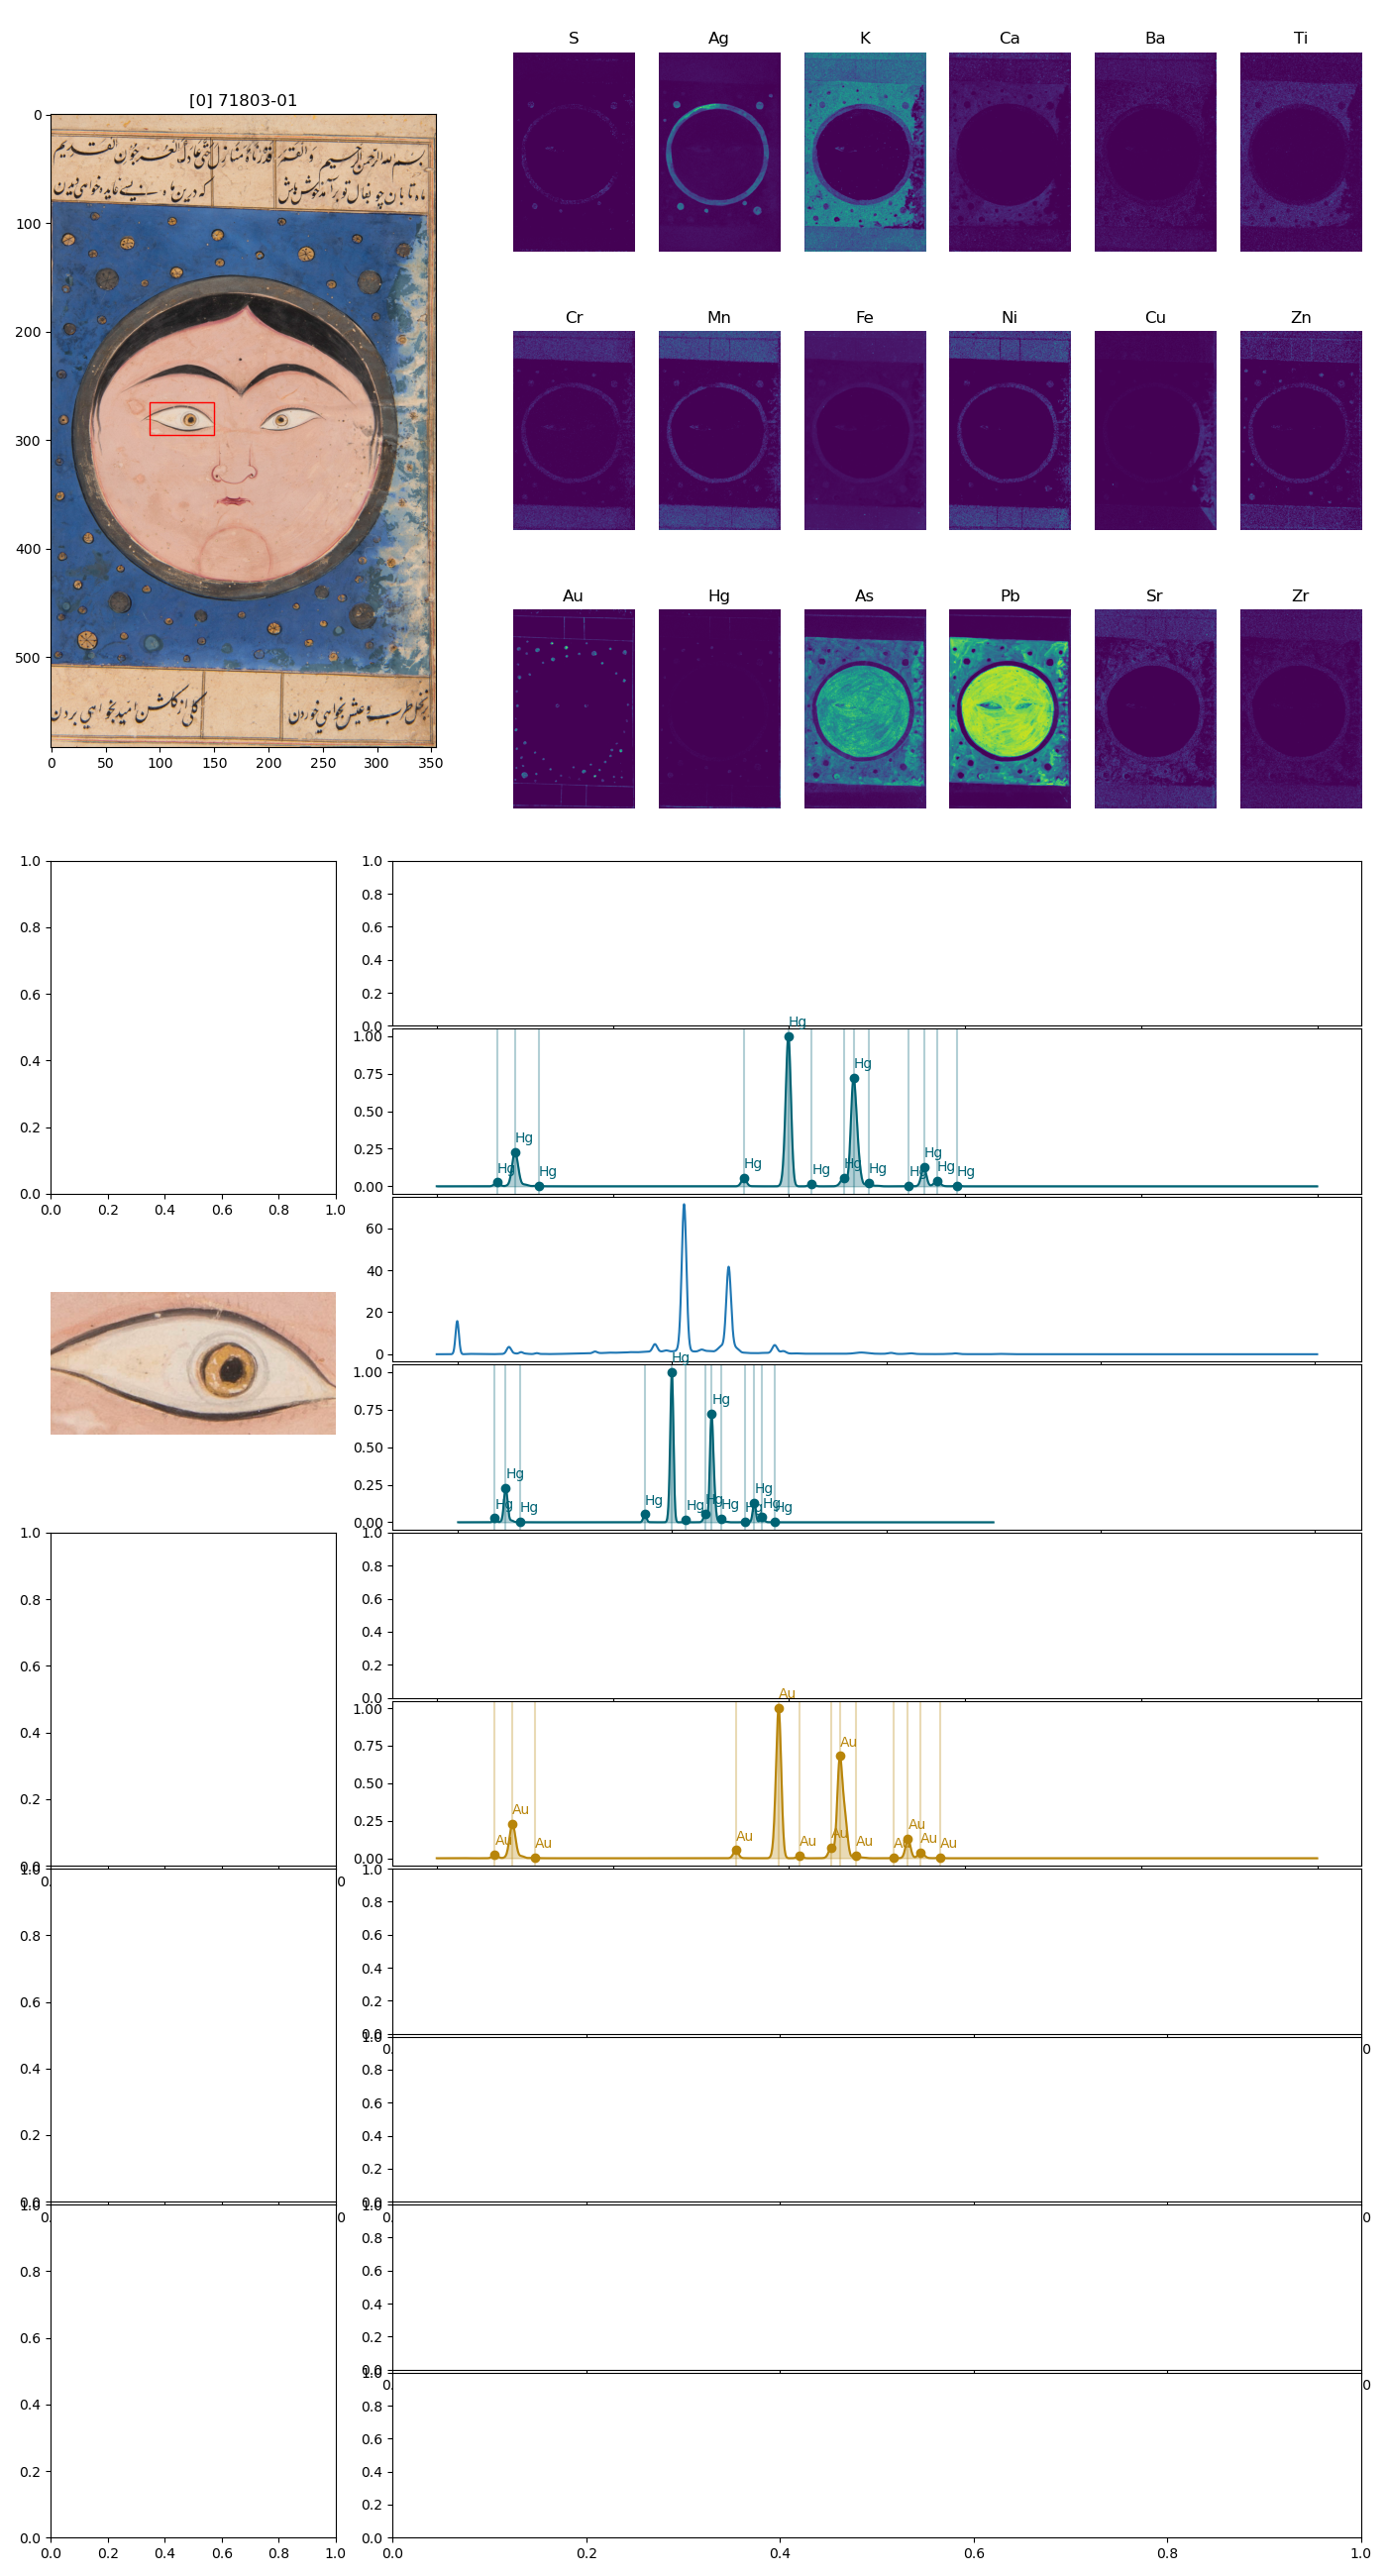

In [15]:
datastack_files = [datastack_file, datastack_file2]
dash = Dashboard(datastack_files, 5, data)

In [9]:
dash.add_roi(1, (90, 150), (265, 295))

In [8]:
dash.add_roi(0, *dash.get_selection_coords())

In [10]:
dash.add_mos_element(1, 'Hg')

/home/koen-van-tilburg/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/moseley/mplot.py:304: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [11]:
dash.add_mos_element(0, 'Hg')

In [12]:
dash.add_mos_element(2, 'Au')

In [13]:
dash.remove_mos_element(1, 'Pb')

Element not in list


In [23]:
dash.swap_image(1)

In [14]:
data = dash.get_data()